# Install libraries

In [1]:
!pip install fuzzywuzzy
!pip install tqdm
!pip install seaborn
!pip install -U ipytest

Requirement already up-to-date: ipytest in c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages (0.9.1)


# Import libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from fuzzywuzzy import fuzz
import itertools
from collections import Counter 
from tqdm import tqdm

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Import sql databases as Dataframes

In [2]:
#create engine to make connection to data base
db_schema = 'sqlite:///data.db'
engine = create_engine(db_schema, echo=False)
con = engine.connect()

#retrieve patient and test dataframes
df_patient = pd.read_sql('select * from patient', con=con)
con.close()

# Data Analysis:
* Verify Missing Values
* Verify data coherences
* Cleaning data

# Verify Missing Values

## display dataframe

In [3]:
#display patient dataframe
display(df_patient)

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,NaN,02 92489054,glenmore
19996,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,07 20549476,None
19997,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,NaN,26.0,03 83466737,None
19998,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,04 41125514,None


## Get data info

In [4]:
#get patient infos
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     20000 non-null  int64  
 1   given_name     19560 non-null  object 
 2   surname        19575 non-null  object 
 3   street_number  19618 non-null  float64
 4   address_1      19204 non-null  object 
 5   suburb         19788 non-null  object 
 6   postcode       19801 non-null  object 
 7   state          18010 non-null  object 
 8   date_of_birth  17989 non-null  float64
 9   age            16003 non-null  float64
 10  phone_number   19081 non-null  object 
 11  address_2      7893 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.8+ MB


On remarque que seulement le patient_id ne contient pas des valeurs nulles.

## Get Missing percentage dataframe

In [5]:
#construct percentage dataframe of missing values in each column
missing_percentage = (pd.isnull(df_patient).sum() / len(df_patient) ) * 100
missing_value_df_patient = pd.DataFrame({'column_name': df_patient.columns,'missing_percentage': missing_percentage})
#sort missing percentage dataframe 
missing_value_df_patient.sort_values('missing_percentage', inplace=True,ascending=False)
missing_value_df_patient

,column_name,missing_percentage
address_2,address_2,60.535
age,age,19.985
date_of_birth,date_of_birth,10.055
state,state,9.950
phone_number,phone_number,4.595
address_1,address_1,3.980
given_name,given_name,2.200
surname,surname,2.125
street_number,street_number,1.910
suburb,suburb,1.060


## Visual missing values

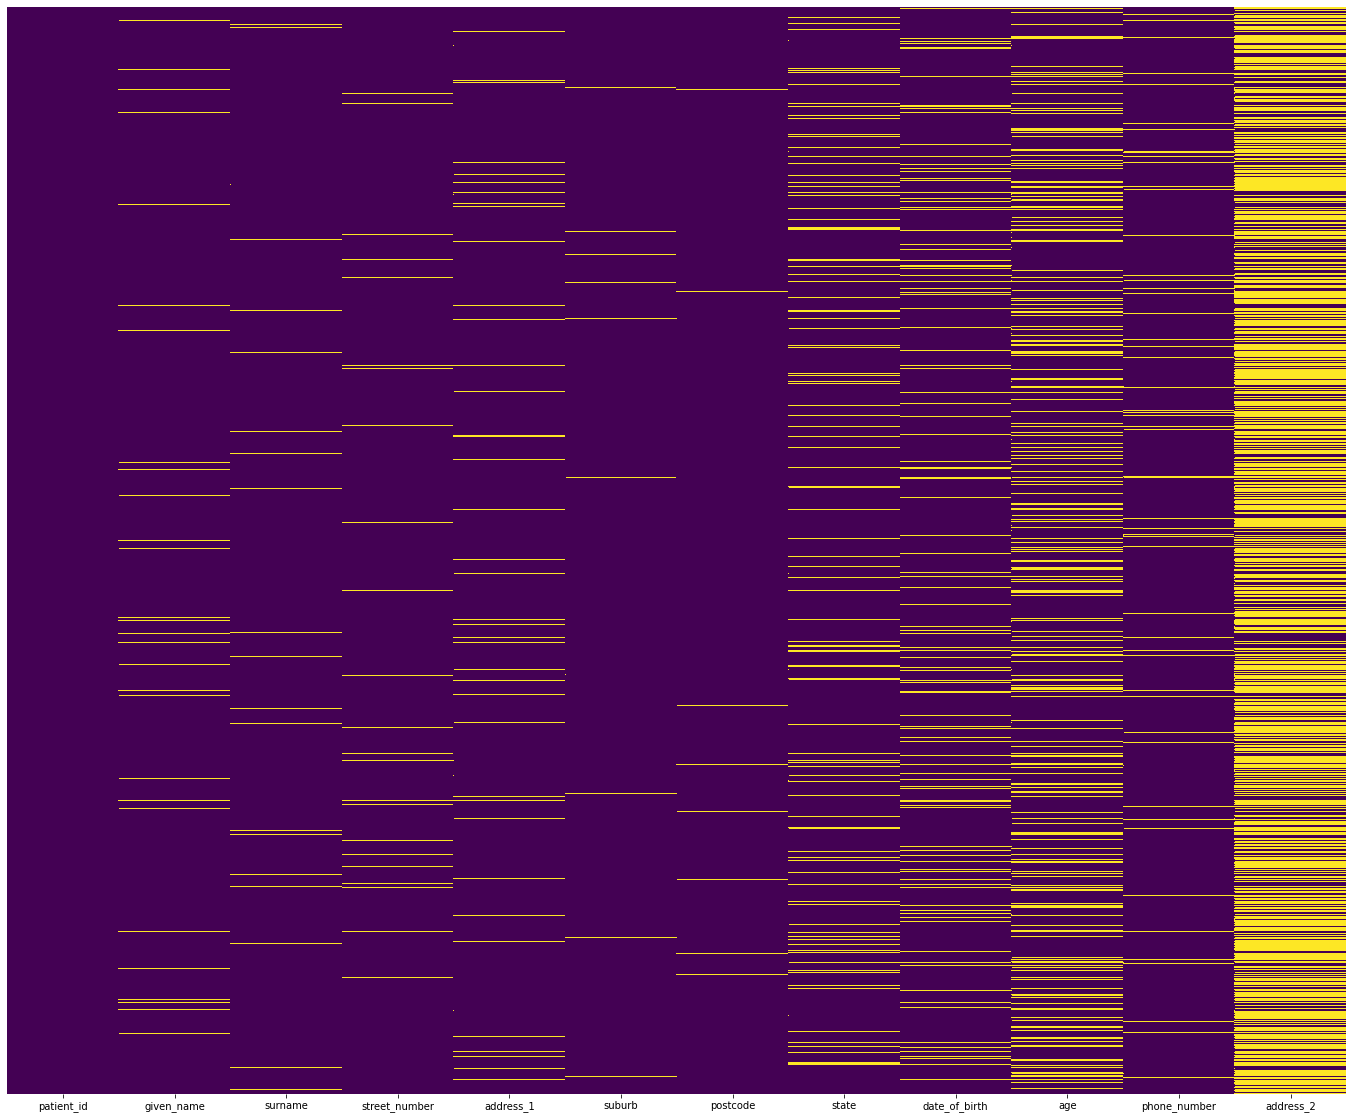

In [6]:
#Verify Missing Values (Yellow lines represent the null values)
plt.figure(figsize=(24,20))
sns.heatmap(pd.isnull(df_patient),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

D'après cet missing_percentage datframe et cette graphe ci dessus on peut remarque que l'attribut address_2 contient plusque 60% de valeurs nulles. Du coup, on ne tiendrai pas en compte dans notre études de données.

## Statistical analysis on our dataframe

In [7]:
#get statistical values on numerical columns
df_patient.describe()

,patient_id,street_number,date_of_birth,age
count,20000.000000,19618.000000,1.798900e+04,16003.000000
mean,553918.938750,98.812468,1.949638e+07,27.534337
std,260234.961111,2481.908686,2.926916e+05,7.807008
min,100005.000000,0.000000,1.290041e+07,0.000000
25%,330194.250000,10.000000,1.924113e+07,24.000000
50%,556327.500000,24.000000,1.950032e+07,29.000000
75%,779419.500000,60.000000,1.975052e+07,33.000000
max,999993.000000,342951.000000,1.999123e+07,92.000000


On pourra conclure que l'attribut age est de max 95 et de moyenne 27 du coup la pluspart des gens sont des adultes et aussi il faut qu'on verifie l'age 0 qui m'apprait illogique d'avoir un age de 0 ans. Aussi, On pourra remarquer que postcode and phone_number attributs ne sont pas des integers c'est pour cela il faut qu'on analyse ces deux colonnes

### Age column analysis

In [8]:
#age column analysis where age value equal to 0
df_patient[df_patient.age == min(df_patient.age)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
2038,353973,hayden,shepherd,18.0,gamor street,nar na r goon,3079,tas,19241106.0,0.0,03 14630666,None
16621,427660,caitlin,riddell,14.0,streetqcarina,st albans,5095,qld,NaN,0.0,08 62513595,None


Seuelement deux lignes contiennent des valeurs nulles pour l'age. Mais le state est valide pour ces deux lignes du coup on a le choix comme ce sont seuelemt deux lignes de les effacer ou les supprimer.

### Phone number column analysis

In [9]:
#remove blank space drom phone numbers
df_patient["phone_number"].apply(lambda x: int(x[:2] + x[3:]) if pd.notnull(x) else x)

0        886018809.0
1        297793152.0
2        220403934.0
3        262832318.0
4        369359594.0
            ...     
19995    292489054.0
19996    720549476.0
19997    383466737.0
19998    441125514.0
19999    752535106.0
Name: phone_number, Length: 20000, dtype: float64

On peut remarquer que la colonne phone number contient des valeurs numériques en plus des valeurs nulles

### Postcode column analysis

In [10]:
#verify if postcode contains numerical values
df_patient[df_patient["postcode"].str.isnumeric()==False]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
3976,810644,juliana,grosvenor,5.0,connelly pace,3023,port noarlunga south,tas,19991215.0,NaN,03 55227740,None
4080,986559,kirra,choi-lundberg,102.0,centaurus street,6168,naremburn,vic,19261104.0,27.0,08 69584599,None
5792,752873,lochlan,blake,258.0,None,4216,toowoobma,wa,19080821.0,31.0,02 84630666,None
6218,902348,isaac,nakoje,19.0,collier street,6017,brighton,None,19640421.0,8.0,02 69439226,None
6618,678110,jaden,green,5.0,dovey place,3185,oraneg,vic,19151204.0,23.0,02 73534391,None
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,None,None
9718,727290,tiffany,loukes,31.0,leal place,467l0,forest hill,nsw,19760706.0,23.0,None,pangani
11333,738103,hugi,pascoe,167.0,leita court,3023,port lincoln,nsw,19040401.0,NaN,07 84786511,None
14255,684359,sonia,green,50.0,kalgoorlie crescent,6112,ashfield,sa,NaN,9.0,03 46671647,None
15479,355033,abby,yoob,243.0,weston street,3181,forest hill,None,19660615.0,26.0,02 68667816,None


D'après cet dataframe, on remarque que certaines lignes que les valeurs postcode et subrub sont inversées. Du coup, il faudra qu'on tienne en compte de ca pour la phase du cleaning data

# Verify data coherences

## Get nunique Values for each column

In [11]:
#get number of unique values per column
df_patient.nunique()

patient_id       19798
given_name        1171
surname           4273
street_number      834
address_1         4326
suburb            2925
postcode          2021
state              102
date_of_birth    13654
age                 58
phone_number     17916
address_2         3460
dtype: int64

In [12]:
#get most common id duplicated
id_duplicated = Counter(df_patient.patient_id).most_common(1)[0][0]
display(df_patient[df_patient.patient_id == id_duplicated])

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
4094,428821,rory,webb,24.0,houghton place,wendouree,3216,tas,19920516.0,31.0,03 35306101,None
5959,428821,chelsea,tulla,23.0,britten-jones drive,ballarat,3057,None,19270809.0,11.0,04 87459349,None
7609,428821,joshua,meuris,25.0,monaro crescent,south melbourne,2285,nsw,19060502.0,NaN,None,doribank


On remarque que le id du patient n'est pas unique et il exisite des doublons ce qui pourrai affecter notre étude. Aussi le nombre de state dans l'australie est environ 102 alors que en réel sont seulement 8 states (["nsw","act","vic","qld","sa","wa","tas","nt"]). Du coup, la il faut qu'on fasse de l'analyse sur la colonne state.

Référence: https://en.wikipedia.org/wiki/Postcodes_in_Australia

### patient_id column analysis

In [16]:
def get_id_duplicates(df):
    
    """get id duplicates values  
    
    Parameters
    ----------
    df : dataframe
        patient informations dataframe
        
    Returns
    -------
    tuple
        contains new dataframe with assigned new ids to duplicates and dictionary contains duplicates id as keys and new assigned ids for the duplicates
    """
    new_df = df.copy()
    dict_ = {}
    i = 0
    
    #verify whether the duplicates on patient id have the same pcr result or not 
    for id,count in Counter(new_df.patient_id).most_common():
        
        #if ids is duplicated
        if count > 1:
            list_new_index = []
            #iterate over rows having the same id
            
            for idx,row in new_df[new_df["patient_id"]==id][1:].iterrows():
                i = i+1
                #assign new ids
                new_df.loc[idx,"patient_id"] = min(new_df["patient_id"])-i
                #get assigned ids into a list
                list_new_index += [min(new_df["patient_id"])-i]
                
            #create a dictionay contains duplicates id as keys and new assigned ids for the duplicates
            dict_[str(id)] = list_new_index
            
    return new_df, dict_

In [13]:
#get df_patient without id_duplicates and dictionary of duplicates and new assigned ids
df_patient, dict_duplicates_id = get_id_duplicates(df_patient)

In [14]:
#verify df_patient new assigned ids
df_patient["patient_id"].nunique()

20000

La on a attribueé de nouveaux ids aux ids dupliqués. La il faut qu'on prenne en considération ces nouveaux ids lors de la jointure avec pcr dataframe

### state column analysis

In [15]:
#display state unique values
df_patient["state"].unique()

array(['wa', 'nsw', 'qld', 'nt', 'sa', None, 'act', 'vic', 'tas', 'vc',
       'qkd', 's', 'qlh', 'nswf', 'ndw', 'nsjw', 'nsza', 'nu', 'vicf',
       'vicb', 'nswt', 'nsg', 'qlf', 'wr', 'vicz', 'nsa', 'wab', 'qxlj',
       'ai', 'qlg', 'vil', 'qln', 'qlc', 'ws', 'qls', 'viv', 'ta', 'nswm',
       'nfw', 'vie', 'nsq', 'nxw', 'nfsw', 'vkc', 'qlr', 'ns', 'naw',
       'ic', 'nwd', 'qod', 'tab', 'nsd', 'vmv', 'fsw', 'vich', 'nwx', 'a',
       'qlt', 'nsc', 'wu', 'nss', 'vucm', 'vix', 'nsy', 'ng', 'nse', 'w',
       'ql', 'sv', 'taz', 'tak', 'vh', 'nze', 'nswb', 'qlz', 'vicm',
       'waw', 'nsew', 'nvq', 'wz', 'gic', 'vid', 'qldg', 'vuv', 'vib',
       'qud', 'nsxw', 'nlw', 'vif', 'nsn', 'nssw', 'nsgs', 'vicw', 'wq',
       'vq', 'nswn', 'tad', 'qle', 'vcci', 'qdd', 'vi', 'qldy', 'nsjh'],
      dtype=object)

On remarque qu'il y a des fautes de frappe lors de l'ecriture du state. Aussi une autre méthode pour l'identification du state à travers le code postale. C'est pour cela on va écrire une fonction qui prend en paramètre un dictionnaire contient les states comme cléfs et le range du code postale comme valeurs. Le but de cette fonction est le calcul du nombre de states non présents dans l'australie (None) et le state qui correspond bien au code postale (True) et finalement au state qui ne correspond pas au code postale saisi (False)

In [17]:
def verify_postcode_state(x,dict_state_postcode):
    
    """Verify data coherences 
    
    Parameters
    ----------
    x : list
        list of patient informations
    dict_state_postcode : dictionary
        dictionary contains australia states as keys and australia postcode range as values
    
    Returns
    -------
    str
        one of these values ("Matched rows","Mismatched rows","wrong states")
    """
    
    
    postcode = x["postcode"]
    state = x["state"]
    
    #verify if postcode contains 0 as a forst letter . example: 0200 postcode
    if str(postcode)[0] == "0":
        postcode = int(str(postcode)[1:])
        
    try:
        if state in dict_state_postcode.keys():
            
            for list_ in dict_state_postcode[state]:
                
                if int(postcode) in list_:
                    return "Matched rows"
                    break
            return "Mismatched rows"
        
        else:
            return "wrong states"  
        
    except:
        
        return "wrong states" 

In [18]:
#dict_state_postcode & list_australia_state using https://en.wikipedia.org/wiki/Postcodes_in_Australia as a referance
dict_state_postcode = {"nsw":[range(1000,2600),range(2619,2900),range(2921,300)],"act":[range(200,300),range(2600,2619),range(2900,2921)],"vic":[range(3000,4000),range(8000,9000)],"qld":[range(4000,5000),range(9000,10000)],"sa":[range(5000,5800),range(5800,6000)],"wa":[range(6000,6798),range(6800,7000)],"tas":[range(7000,8000)],"nt":[range(800,1000)]}
match_postcode_state = df_patient.apply(verify_postcode_state,args=(dict_state_postcode,),axis=1)
match_postcode_state_df = pd.DataFrame({'match_postcode_state': match_postcode_state})

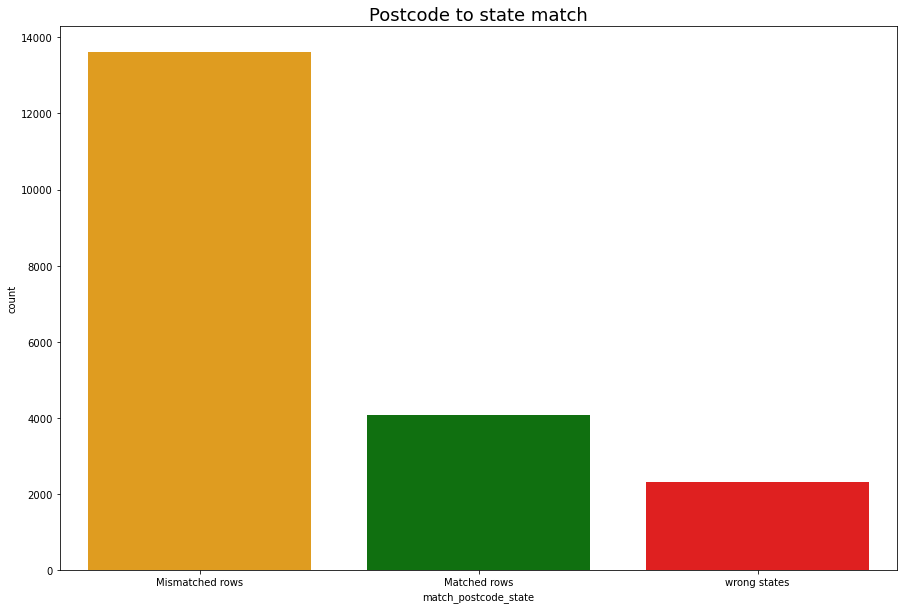

In [19]:
#Visualize postcode to state match
plt.figure(figsize=(15,10))
sns.countplot(x='match_postcode_state',data=match_postcode_state_df,palette = ["orange","green","red"]).set_title("Postcode to state match",fontsize=18)
plt.show()

D'après cette figure, on remarque qu'il y a un problème d'incohérence de données. En fait, le nombre de mismatched lignes ( les lignes ayant un state et code postale valide alors que le postcode ne matche pas le state défini) est plus élevé par rapport les matched lignes ( les lignes ayant un state et code postale valide et le postcode correspond bien au state défini) et les wrong states (les lignes ayant des states qui n'appartiennent pas aux states de l'australie). On pourra résoudre ce problème en utilisant des apis pour la vérification des données (adresse_1, codepostale, state) pour qu'on puisse prédire les bonnes valeurs

# Cleaning Data

Comme discuté, Il faut qu'on fasse le cleaning du data sur les colonnes postocode et phone number pour supprimer l'espace dans les numéros qui pourront après affecter nos études sur les données

In [21]:
def clean_postcode_data(x): 
    
    """Verify if postcode data contains an integer 
    Otherwise we verify other columns ( suburb & adress_1) to see if there is typo problem 
    
    Parameters
    ----------
    x : list
        list of patient informations
    
    Returns
    -------
    list
        list having a valid postcode position
    """
    
    try:
        #try if postcode is an integer
        int(x["postcode"])
        return x
    except:
        try:
            #if postcode is not an integer then try if suburb is an integer
            int(x["suburb"])
            #switch postocde and suburb values
            x_postcode = x["postcode"]
            x["postcode"] = x["suburb"]
            x["suburb"] = x_postcode
            return x
        except:
            try:
                #if postcode & suburb are not integers then try if address_1 is an integer
                int(x["address_1"])
                #switch postocde and address_1 values
                x_postcode = x["postcode"]
                x["postcode"] = x["address_1"]
                x["address_1"] = x_postcode
                return x
            except:
                return x

def clean_phone_number_data(x):
    
    """remove blank space from phone number 
    
    Parameters
    ----------
    x : list
        list of patient informations
    
    Returns
    -------
    list
        a list with phone number column without blank space
    """
    
    #verify if phone_number value is null value
    if pd.notnull(x["phone_number"]):
        #remove blan space which alwaus in 3rd position
        x["phone_number"] = x["phone_number"][:2] + x["phone_number"][3:]
        return (x)
    
    else:    
        return(x)

In [22]:
#postcode and phone number columns cleaning 
df_patient = df_patient.apply(clean_postcode_data,axis=1)
df_patient = df_patient.apply(clean_phone_number_data,axis=1)

## Verify data cleaning on our dataframe

In [23]:
#verify if postcode contains numerical values
df_patient[df_patient["postcode"].str.isnumeric()==False]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
9718,727290,tiffany,loukes,31.0,leal place,467l0,forest hill,nsw,19760706.0,23.0,None,pangani


On remarque que suelment cette ligne n'a pas été changée car la valeur de suburn est 467l0 du coup il s'agit pas d'un numéro car au lieu de taper "1" la personne a tapé "l". Pour résoudre ce problème, on peut aplliquer une fonction qui détécte le pourcentage qu"une chaine de caractère soit un numéro. Mais comme il s'agit d'un seul élèment on pourra l'ignorer en ce moment la.

In [24]:
#verify phone number column
df_patient["phone_number"].head()

0    0886018809
1    0297793152
2    0220403934
3    0262832318
4    0369359594
Name: phone_number, dtype: object

## save cleaned dataframe into patient_cleaned table

In [29]:
# Verify list fo tables in our database
engine = create_engine(db_schema, echo=False)
con = engine.connect()
con.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[('patient',), ('test',)]

In [30]:
#save new_data_frame as a table to our database
df_patient.to_sql('patient_cleaned', con=con, if_exists='replace',index=False)

# Deduplicates function

## Detect duplicates secondary functions

In [31]:
def same_string(s1, s2):
    
    """Verify whether two string are equal
    
    Parameters
    ----------
    s1 : str
        first string 
    s2 : str
        second string to be compared to s1
    
    Returns
    -------
    tuple
        a tuple contains a boolean value True if they are equal otherwise False and an integer value 1 if two strings are not null and -1 if one of them is null
    """
    
    #compare two strings if s1 and s2 are not null values
    if pd.notnull(s1) & pd.notnull(s2):
        return s1.lower() == s2.lower(),1
    else:
        return False,-1
    
def similar_string(s1, s2, percentage):

    """Verify whether two string are similar
    
    Parameters
    ----------
    s1 : str
        first string 
    s2 : str
        second string to be compared to s1
    percentage : integer
        threshold to define whther s1 and s2 are similar
    
    Returns
    -------
    tuple
        a tuple contains a boolean value True if they are similar otherwise False and an integer value 1 if two strings are not null and -1 if one of them is null
    """
    
    #compare two strings if s1 and s2 are not null values
    if pd.notnull(s1) & pd.notnull(s2):
        return fuzz.ratio(s1, s2) >= percentage,1
    else:
        return False,-1
     
def similar_row(df, list_similar, list_same, row1, row2, group_by, similarity_string_thresh, similarity_row_thresh):
    
    """Verify whether two rows are similar
    
    Parameters
    ----------
    df: dataframe
        dataframe patient to get element indexes 
    list_similar: list
        list of items in each row wanted to be similar to compute similarity betwwen two rows
    list_same: list
        list of items in each row wanted to be same to compute similarity betwwen two rows   
    row1 : list
        row contains all information of one patient
    row2 : list
        row contains all information of one patient to be compared to row1
    group_by : string
        a column of patient dataframe to be grouped by
    similarity_string_thresh : integer
        threshold to be used to compute similarity between two strings
    similarity_row_thresh : float
        threshold to be used to make a decision whether two row are similar (from 0 to 1)
    
    Returns
    -------
    boolean
        a boolean value True if they are similar otherwise False 
    """
    
    #initialize count and count_total values
    count = 0
    count_total = 0
    
    #iterate over list_similar
    for element in list_similar:
        #verify if element equal to group_by
        
        if element !=group_by:
            #compute similarity between two strings of this element
            s1 = str(row1[df_patient.columns.tolist().index(element)])
            s2 = str(row2[df_patient.columns.tolist().index(element)])
            
            if similar_string(s1, s2, similarity_string_thresh) == (True,1):
                count += 1
                count_total += 1
            elif similar_string(s1, s2, similarity_string_thresh) == (False,1):
                count_total += 1
                
    #iterate over list_same
    for element_ in list_same:
        
        #verify if element equal to group_by
        if element_ !=group_by:
            s1 = str(row1[df_patient.columns.tolist().index(element_)])
            s2 = str(row2[df_patient.columns.tolist().index(element_)])
            
            #compute similarity between two strings of this element
            if same_string(s1, s2) == (True,1):
                count += 1
                count_total += 1
            elif same_string(s1, s2) == (False,1):
                count_total += 1

    #compute count/count_total and compare it to the fixed threshold     
    return count/count_total  > similarity_row_thresh

def verify_count_values(row_1, row_2, set_duplicates):
    
    """Compute number of null values of two rows and keep the row having the minimal number of null values
    
    Parameters
    ----------
    row_1 : list
        contains patient informations
    row_2 : list
        another row contains patient informations
    set_duplicates : set
        contains patient_id of the row contains less null values
        
    Returns
    -------
    set
        contains patient_id of the row contains much null values
    """
    #compare count_null_values of row_1 and row_2
    if pd.isnull(row_1).sum() < pd.isnull(row_2).sum()  :
        set_duplicates.add(row_2[0])
    else:
        set_duplicates.add(row_1[0])

    #return all patient_ids that contain much null values
    return set_duplicates

def add_duplicates(row_1, row_2, idx_state, list_australia_state, set_duplicates):
    
    """Compare two rows and keep the row does not have a valid postcode belonging to the list of austrlia states to be deleted
    
    Parameters
    ----------
    row_1 : list
        contains patient informations
    row_2 : list
        another row contains patient informations
    idx_state : integer
        index of state value in the patient informations row 
    list_australia_state : list
        contains the valid australia state
    set_duplicates : set
        contains patient_id of the row contains a valid postcode
        
    Returns
    -------
    set
        contains patient_id of the row which not contains a valid postcode
    """
    
    #check whether if state of row_1 & row_2 having valid postcode
    if (row_1[idx_state] in list_australia_state and row_2[idx_state] in list_australia_state):
        set_duplicates = verify_count_values(row_1, row_2, set_duplicates)
        
    #check whether if only state of row_1 having valid postcode
    elif row_1[7] in list_australia_state:
        set_duplicates.add(row_2[0])
        
    #check whether if only state of row_2 having valid postcode
    elif row_2[7] in list_australia_state:
        set_duplicates.add(row_1[0])
        
    else:
        set_duplicates = verify_count_values(row_1, row_2, set_duplicates)
    
    #return all patient_ids do not contain a valid postcode
    return set_duplicates

In [32]:
def detect_duplicates(df, list_similar, list_same, list_by_group, list_aus_state, similarity_string_thresh=75, similarity_row_thresh=0.5):
    
    """Compare two rows and keep the row does not have a valid postcode belonging to the list of austrlia states to be deleted
    
    Parameters
    ----------
    df: dataframe
        dataframe patient to get state indexe 
    list_similar : list
        list of items in each row wanted to be similar to compute similarity betwwen two rows
    list_same : list
        list of items in each row wanted to be same to compute similarity betwwen two rows
    list_by_group : list
        list of items to be grouped by
    list_aus_state : list
        contains the valid australia state
    
    similarity_string_thresh : integer
        threshold to be used to compute similarity between two strings
    similarity_row_thresh : float
        threshold to be used to make a decision whether two row are similar (from 0 to 1)
                
    Returns
    -------
    tuple : integer,dataframe
        sum of duplicates plus new dataframes without duplicates
    """
    #copy of dataframe
    df_new_patient = df.copy()
    #get state index
    idx_state = df_new_patient.columns.tolist().index("state")
    #initalize sum of duplicates
    sum_duplicates = 0
    
    #iterate over list_by_group to group dataframe by each element
    for j in range(len(list_by_group)):
        
        #get by_group value
        by_group = list_by_group[j]
        #set iteration value to be printed
        iteration = str(j+1)+"/"+str(len(list_by_group))
        #get blocks fo datat when grouping dataframe by by_group value
        blocks = df_new_patient.groupby(by_group)
        #initalize set of dupliactes to be removed
        set_duplicates = set()
        list_rows = []
        
        #iterate over blocks
        for block in tqdm(blocks,desc="{} :detect duplicates by grouping by {}".format(iteration,by_group),position=0, leave=True):
            
            for i, block_ in enumerate(block):
                if i==1:
                    #using iteratools to speed up computation and get a list of all combination of two items in a list
                    combination_2 = itertools.combinations(block_.values.tolist(),2)
                    
                    while True: 
                        
                        try: 
                            # Iterate by calling next 
                            row_1,row_2 = next(combination_2) 
                            #verify whether two rows are similar
                            
                            if similar_row(df_new_patient,list_similar,list_same,row_1,row_2,by_group,similarity_string_thresh,similarity_row_thresh):
                                #add row do not have a valid postocde and having much null values to be deleted
                                set_duplicates = add_duplicates(row_1, row_2, idx_state, list_aus_state, set_duplicates) 
                                
                        except StopIteration: 
                            # exception will happen when iteration will over 
                            break
                            
        #update sum duplicates values
        sum_duplicates += len(set_duplicates)
        #get list of patient_ids will be kept
        new_patient_id_list = set(df_new_patient.patient_id) - set_duplicates
        #update new patient dataframe
        df_new_patient = df_new_patient[df_new_patient.patient_id.isin(new_patient_id_list)]
        
    return sum_duplicates, df_new_patient

In [33]:
#Initialize parameters
list_same = ['street_number','age','phone_number']
list_similar = ['given_name', 'surname', 'address_1','suburb','date_of_birth']
list_by_group = ['given_name','surname','address_1','suburb','postcode']
list_australia_state = ["nsw","act","vic","qld","sa","wa","tas","nt"]
#get new data frame
sum_duplicates, df_new_patient = detect_duplicates(df_patient, list_similar, list_same, list_by_group, list_australia_state)

5/5 :detect duplicates by grouping by postcode: 100%|██████████████████████████████| 1969/1969 [01:12<00:00, 27.15it/s]


In [34]:
#display new dataframe
df_new_patient

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,0886018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,0297793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,0220403934,None
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,0369359594,None
5,744167,ky,laing,448.0,nyawi place,barmera,3556,qld,19050919.0,32.0,0359872070,None
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,NaN,0292489054,glenmore
19996,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,0720549476,None
19997,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,NaN,26.0,0383466737,None
19998,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,0441125514,None


In [35]:
#construct duplicates number pdf contains count of duplicates and non duplicates
duplicates_number_df = pd.DataFrame([sum_duplicates,len(df_patient)-sum_duplicates],index=['duplicates', 'non_duplicates'],columns=["sum"])
duplicates_number_df

,sum
duplicates,1395
non_duplicates,18605


## Plot count duplicates Vs Non duplicates 

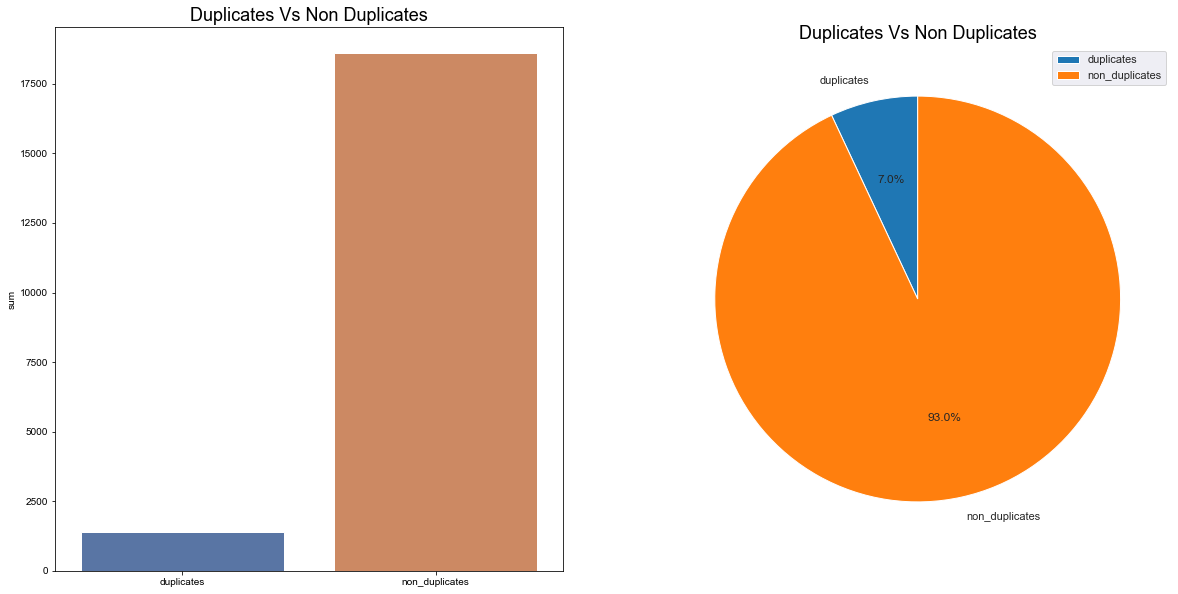

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.set(style="darkgrid")
sns.barplot(x=duplicates_number_df.index,y="sum", data=duplicates_number_df,ax=ax1)

# defining labels 
activities = duplicates_number_df.index  
# portion covered by each label 
slices = duplicates_number_df["sum"]
# color for each label 
  
# plotting the pie chart 
ax2.pie(slices, labels = activities,  
        startangle=90, 
        radius = 1, autopct = '%1.1f%%') 

# plotting legend 
ax2.legend(loc="upper right")

# plotting titles 
ax1.set_title("Duplicates Vs Non Duplicates", fontsize=18)
ax2.set_title("Duplicates Vs Non Duplicates", fontsize=18)

plt.show()

Selon ces graphes, notre dataframe a un pourcentage de 7% de données qui sont dupliquées

In [42]:
#verify nunique values
df_new_patient["state"].unique()

array(['wa', 'nsw', 'qld', 'nt', None, 'act', 'vic', 'sa', 'tas'],
      dtype=object)

Finalement, après supprimer du duplicates on remarque qu'on a des 9 states: 8 sont les states de l'austrlie et un autre None. La on remarque l'importance de la condition ajoutée avant de supprimer la ligne qui consiste a vérifier si deux lignes sont similaires on supprime celle qui contient un state non valide

## save new data frame without duplicates

In [37]:
# Verify list fo tables in our database
engine = create_engine(db_schema, echo=False)
con = engine.connect()
con.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[('patient',), ('test',), ('patient_cleaned',)]

In [38]:
#save new_data_frame as a table to our database
df_new_patient.to_sql('new_patient', con=con, if_exists='replace',index=False)

In [39]:
df_new_patient.nunique()

patient_id       18605
given_name         967
surname           4010
street_number      816
address_1         4083
suburb            2714
postcode          1969
state                8
date_of_birth    13439
age                 51
phone_number     17749
address_2         3422
dtype: int64

In [40]:
#test added data
df_new_patient_ = pd.read_sql('select * from new_patient', con=con)
df_new_patient_

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,0886018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,0297793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,0220403934,None
3,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,0369359594,None
4,744167,ky,laing,448.0,nyawi place,barmera,3556,qld,19050919.0,32.0,0359872070,None
...,...,...,...,...,...,...,...,...,...,...,...,...
18600,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,NaN,0292489054,glenmore
18601,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,0720549476,None
18602,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,NaN,26.0,0383466737,None
18603,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,0441125514,None


# Test secondary functions to construct detect_duplicates function
Ref: https://github.com/chmp/ipytest/blob/master

In [41]:
import pytest
import ipytest
ipytest.autoconfig()

## Test same_string function

In [42]:
%%run_pytest[clean]

@pytest.mark.parametrize('input_same_string,expected_same_string', [
    (("inria", "Inria"),(True,1)),
    (("inria", "inria"),(True,1)),
    (("inria", "nria"),(False,1)),
    (("inria", None),(False,-1)),
    (("0355227740", "0355227740"),(True,1)),
    (("0355227740", "0355227741"),(False,1))

])
def test_same_string(input_same_string, expected_same_string):
    assert same_string(*input_same_string) == expected_same_string

......                                                                                                           [100%]
6 passed in 0.13s


## Test similar_string function

In [43]:
%%run_pytest[clean] 

@pytest.mark.parametrize('input_similar_string,expected_similar_string', [
    (("inria", "Inria",75),(True,1)),
    (("inria", "inria",75),(True,1)),
    (("inria", "nria",75),(True,1)),
    (("inria", None,75),(False,-1)),
    (("0385237740", "0355227740",75),(True,1)),
    (("redfern street", "redfernsrreet",75),(True,1)),
    (("Oussemz", "Osemaa",60),(True,1))

])
def test_similar_string(input_similar_string, expected_similar_string):
    assert similar_string(*input_similar_string) == expected_similar_string

.......                                                                                                          [100%]
7 passed in 0.03s


## Test similar_row function which computes similarity between two rows

In [44]:
%%run_pytest[clean]

#apply same_string function on these elements
list_same = ['street_number','age','phone_number']
#apply similar_string function on these elements
list_similar = ['given_name', 'surname', 'address_1','suburb','date_of_birth']
#couple of variables to be tested

row_1 = [302053, 'abbey', 'mcgregor', 107.0, 'maclagan street', 'kardinya', '3977', 'qld', 19930909.0, np.nan, '0460018297', 'wyuna']
row_1_test = [756578, 'abbey', 'mcgrrgoe', 107.0, 'maclagan street', 'kardinya', '3977', 'qld', 19000819.0, np.nan, '0460018297', 'wyuna']
 
row_2 = [282051, 'abby', 'gerafhty', 4.0, 'bird place', 'macquarie fields', '2210', 'nsw', 19470921.0, 27.0, '0731638236', 'riverbdnd']
row_2_test =[456007, 'abby', 'geraghty', 48.0, 'bird place', 'macquaqrie field', '2210', 'nsw', 19470921.0, 32.0, '0731638236', 'riverbend']
 
row_3 = [522515, 'jaiden', 'ryan', 23.0, 'roderick street', 'raglan', '7330', 'vic', 19860317.0, 74.0, '0440865082', None]
row_3_test = [279559, 'jaides', 'ryan', 23.0, 'roderick street', 'raglna', '7330', 'vic', 19860317.0, 27.0, '0440765082', 'glengallan']

row_4 = [706782, 'joel', 'lund', 24.0, 'williamson street', 'blacktown', '5092', 'vic', 19810614.0, np.nan, '0497454645', 'mt pleasant']
row_4_test = [662667, 'braedon', 'joel', 24.0, 'williamson street', 'blacktown', '5092', 'vic', 19810614.0, np.nan, '0497454645', 'mt pleasant']

row_5 = [596507, 'karixpsa', None, 7.0, 'leith place', 'williamstown', '4520', 'vic', 19080117.0, 27.0, '0410033391', 'kieta']
row_5_test = [497477, 'morrison', 'karissa', 7.0, 'leith pnace', 'williamstown', '4520', 'vic', 19080117.0, 27.0, '0410033391', 'kieta']

row_6 = [377785, 'natalre', 'madigatn', 13.0, None, 'prospect', '3023', None, np.nan, np.nan, '0224976027', 'meath mews retrmnt vlge']
row_6_test = [968948, 'natalee', 'madigan', 13.0, None, 'prospwct', '3023', None, 19450824.0, np.nan, '0224967027', None]

row_7 = [723502, 'abby', 'jobber', 50.0, 'maidment place', 'lalor', '4670', 'nsw', 19350823.0, 32.0, '0364887627', 'kinnoul']
row_7_test = [456007, 'abby', 'geraghty', 48.0, 'bird place', 'macquaqrie field', '2210', 'nsw', 19470921.0, 32.0, '0731638236', 'riverbend']

@pytest.mark.parametrize('input_similar_row,expected_similar_row', [
    ((df_patient, list_similar, list_same, row_1, row_1_test, 'given_name', 75, 0.5),True),
    ((df_patient, list_similar, list_same, row_2, row_2_test, 'given_name', 75, 0.5),True),
    ((df_patient, list_similar, list_same, row_3, row_3_test, 'surname', 75, 0.5),True),
    ((df_patient, list_similar, list_same, row_4, row_4_test, 'address_1', 75, 0.5),True),
    ((df_patient, list_similar, list_same, row_5, row_5_test, 'suburb', 75, 0.5),True),
    ((df_patient, list_similar, list_same, row_6, row_6_test, 'postcode', 75, 0.5),True),
    ((df_patient, list_similar, list_same, row_7, row_7_test, 'given_name', 75, 0.5),False)
])

def test_similar_row(input_similar_row, expected_similar_row):
    assert similar_row(*input_similar_row) == expected_similar_row

.......                                                                                                          [100%]
7 passed in 0.03s


## Test verify_count_values function

In [46]:
%%run_pytest[clean]

row_4 = [706782, 'joel', 'lund', 24.0, 'williamson street', 'blacktown', '5092', 'vic', 19810614.0, np.nan, '0497454645', 'mt pleasant']
row_4_test = [662667, 'braedon', 'joel', 24.0, 'williamson street', 'blacktown', '5092', 'vic', 19810614.0, np.nan, '0497454645', 'mt pleasant']

row_5 = [596507, 'karixpsa', None, 7.0, 'leith place', 'williamstown', '4520', 'vic', 19080117.0, 27.0, '0410033391', 'kieta']
row_5_test = [497477, 'morrison', 'karissa', 7.0, 'leith pnace', 'williamstown', '4520', 'vic', 19080117.0, 27.0, '0410033391', 'kieta']

@pytest.mark.parametrize('input_verify_count_values,expected_set', [
    ((row_4, row_4_test, set()),{row_4[0]}),
    ((row_5, row_5_test, set()),{row_5[0]})
])

def test_verify_count_values(input_verify_count_values, expected_set):
    assert verify_count_values(*input_verify_count_values) == expected_set

..                                                                                                               [100%]
2 passed in 0.02s


## Test add_duplicates function which consists of removing rows having wrong state name and contains much nulladd_duplicates values

In [47]:
%%run_pytest[clean]

list_australia_state = ["nsw","act","vic","qld","sa","wa","tas","nt"]
idx_state = df_patient.columns.tolist().index("state")

row_1 = [355719, 'abby', 'gilksi', 2.0, 'stacy street', 'pascoe vale south', '2022', None, np.nan, 35.0, '0740964334', 'morago']
row_1_test = [527443, 'abby', 'gillis', 2.0, 'stacy srreet', 'pascoe vale south', '2022', 'qld', np.nan, 35.0, '0740974354', 'morago']

row_2 = [249457, 'tiffany', 'loulps', 31.0, 'leal place', 'forest hill', '4670', 'ns', 19760706.0, 23.0, None, 'pangani']
row_2_test = [727290, 'tiffany', 'loukes', 31.0, 'leal place', '467l0', 'forest hill', 'nsw', 19760706.0, 23.0, None, 'pangani']

row_3 = [958286, 'nicholas', 'jankunas', 27.0, 'wakefield avenue', 'wingham', '5019', 'nsw', 19521229.0, np.nan, '0496643830', None]
row_3_test = [161260, 'nicholas', 'jankuas', 27.0, 'wakefield avenue', 'wingham', '5019', 'nswb', 19521292.0, np.nan, '0496643830', None]


@pytest.mark.parametrize('input_add_duplicates,expected_set', [
    ((row_1, row_1_test, idx_state, list_australia_state,set()),{row_1[0]}),
    ((row_2, row_2_test, idx_state, list_australia_state,set()),{row_2[0]}),
    ((row_3, row_3_test, idx_state, list_australia_state,set()),{row_3_test[0]})
])

def test_add_duplicates(input_add_duplicates, expected_set):
    assert add_duplicates(*input_add_duplicates) == expected_set

...                                                                                                              [100%]
3 passed in 0.02s
